# Sentiment analysis 

This is a jupyter notebook for a project to detect the sentiments of movie reviews.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print('hello world!')

hello world!


In [3]:
print(tf.__version__)

2.16.2


## Import dataset
We will use a dataset of movie reviews from IMDB, provided by [stanford university](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz).
Then, we use the get_file function from keras (included in tensorflow) to download the dataset if it is not already in the cache_dir.

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='data',
                                  cache_subdir='')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 143s 2us/step


We define variables for the directories where the data is stored. Directories contain a text file for each review, positive ones are in the 
_pos_ directory and negative are in the _neg_ directory.

In [5]:
dataset_dir=os.path.join(os.path.dirname(dataset), 'aclImdb')
train=os.path.join(dataset_dir,'train')
test=os.path.join(dataset_dir,'test')

We will remove the _unsup_ directory in the train data, as we will use supervised learning for this project (and this will simplify data
loading in the following step)

In [6]:
remove=os.path.join(train,'unsup')
shutil.rmtree(remove)

To load the data, we will use the _text_dataset_from_directory_ function in keras to load the data to memory. This function expect the 
structure 
```text
dir/
    class_1/
        point_1.txt
        point_2.txt
    class_2/
        point_1.txt
        point_2.txt
```
which is conveniently followed by the dataset. In this case, neg will have the label 0 and pos the label 1. 
The dataset will be loaded in batches of 32 points (so it will yield groups of 32 points on each iteration) and the value 40 is used
as a random seed for shuffling. It also will reserve 20% of the dataset for validation (used to tune hyperparameters)

In [7]:
batch_size = 32
seed = 40

raw_training_ds = tf.keras.utils.text_dataset_from_directory(
    train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
print("Label 0 corresponds to", raw_training_ds.class_names[0])
print("Label 1 corresponds to", raw_training_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [9]:
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [10]:
raw_testing_ds = tf.keras.utils.text_dataset_from_directory(
    test,
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [12]:
max_tokens = 10000
sequence_length = 250

#TODO: use glove embeddings

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization, #A function that is called for each input to standarize it
    max_tokens=max_tokens, #maximum size of the vocabulary (it will have the "top max_tokens" words)
    output_mode='int', #return an int for each word
    output_sequence_length=sequence_length #TODO check!
    )

In [13]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_training_ds.map(lambda x, y: x)
#build a vocabulary of all tokens in the dataset
vectorize_layer.adapt(train_text) 

In [14]:
def vectorize_text(text, label):
  # print('previous expansion', vectorize_layer(text))
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_training_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_training_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'I still liked it though. Warren Beatty is only fair as the comic book hero. What saves this movie is the set, the incredible cast and it offshoots a mediocre script. I really expected something more substantial in the terms of action, or plot but I got very little. The main reason to watch this movie is to watch some of the biggest stars in Hollywood at the time in such an unusual film. <br /><br />The one person who did a terrible job and did not even belong in this film was Madonna. She did not belong in this movie and her acting job was pretty bad. The movie at some points just stood still. You expected something more and you got nothing. Al Pacino plays a really bad dude and he does pretty good. He and Beatty do make an excellent good guy and bad guy. <br /><br />It is also interesting to see Dustin Hoffman, and Warren Beatty in a film other than Isthar. I did not see Ishtar but I heard bad things. The thing about this movie is it is good, but it could have been 

Import embeddings from GloVe, with the 100d version

In [16]:
def load_embeddings(path):
    ans = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            ans[word] = vector
    return ans 

In [17]:
url = "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
embeddings_file = tf.keras.utils.get_file("glove.6B", url,
                                  extract=True, cache_dir='data',
                                  archive_format='zip',cache_subdir='glove.6B')

862182613/862182613 ━━━━━━━━━━━━━━━━━━━━ 1072s 1us/step


In [18]:
path = 'data/glove.6B/glove.6B.100d.txt'
embeddings = load_embeddings(path)
print(embeddings['hello'])

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.27326    0.15636   -0.20334
  0.53586    0.59784   

Create a matrix to use in the embedding layer with the current vocabulary, where the i-th vector of the matrix is the embedding for the i-th word

In [19]:
vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
num_tokens = len(vocabulary) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits+=1
    else:
        misses+=1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9888 words (112 misses)


In [20]:
train_ds = raw_training_ds.map(vectorize_text)
val_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_testing_ds.map(vectorize_text)

In [21]:
autotune = tf.data.AUTOTUNE #dynamically change buffer size
train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

# The neural network

In [25]:

bidirectional_model = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim, trainable=False,weights=[embedding_matrix]), #transform the word index into a vector of dimension embedding_dim (16)
  layers.Dropout(0.2), # prevent overfitting
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)])
LSTM_model =  tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim, trainable=False,weights=[embedding_matrix]), #transform the word index into a vector of dimension embedding_dim (16)
  layers.Dropout(0.2), # prevent overfitting
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)])
average_model = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim, trainable=False,weights=[embedding_matrix]), #transform the word index into a vector of dimension embedding_dim (16)
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

CNN_model = tf.keras.Sequential([
    layers.Embedding(num_tokens, embedding_dim, trainable=False,weights=[embedding_matrix]), #transform the word index into a vector of dimension embedding_dim (16)
    layers.Conv1D(250 , 3, padding='valid',
                 activation='relu', strides=1),
    layers.GlobalMaxPooling1D(),
    layers.Dense(250  , activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

bidirectional_model.summary()

# Note: model.summary() outputs wrong  Trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,200 (3.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,200 (3.82 MB)

In [26]:
bidirectional_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
LSTM_model.compile(loss=losses.BinaryCrossentropy(),optimizer='adam',metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
average_model.compile(loss=losses.BinaryCrossentropy(),optimizer='adam',metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
CNN_model.compile(loss=losses.BinaryCrossentropy(),optimizer='adam',metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

# Training

In [27]:
epochs = 10
history_bidirectional_model = bidirectional_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)
history_LSTM_model = LSTM_model.fit(train_ds,validation_data=val_ds,epochs=epochs)
history_average_model = average_model.fit(train_ds,validation_data=val_ds,epochs=epochs)
history_CNN_model = CNN_model.fit(train_ds,validation_data=val_ds,epochs=epochs)

625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - binary_accuracy: 0.5676 - loss: 0.6644 - val_binary_accuracy: 0.7344 - val_loss: 0.5885
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - binary_accuracy: 0.7818 - loss: 0.4862 - val_binary_accuracy: 0.5816 - val_loss: 0.8583
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - binary_accuracy: 0.7200 - loss: 0.5675 - val_binary_accuracy: 0.8224 - val_loss: 0.4637
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - binary_accuracy: 0.8082 - loss: 0.4466 - val_binary_accuracy: 0.5592 - val_loss: 0.5869
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - binary_accuracy: 0.7871 - loss: 0.5143 - val_binary_accuracy: 0.8302 - val_loss: 0.4250
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - binary_accuracy: 0.8250 - loss: 0.4322 - val_binary_accuracy: 0.8302 - val_loss: 0.3923
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - binary_accuracy: 0.8196 - loss: 0.4160 - val_binary_accuracy: 0.8230 - val_loss: 0.4352
Ep

# Test model

In [28]:
loss_bidirectional_model, accuracy_bidirectional_model = bidirectional_model.evaluate(test_ds)
loss_LSTM_model, accuracy_LSTM_model = LSTM_model.evaluate(test_ds)
loss_average_model, accuracy_average_model = average_model.evaluate(test_ds)
loss_CNN_model, accuracy_CNN_model = CNN_model.evaluate(test_ds)

print("Loss: ", loss_bidirectional_model)
print("Accuracy: ", accuracy_bidirectional_model)

782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - binary_accuracy: 0.7602 - loss: 0.5096
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - binary_accuracy: 0.8218 - loss: 0.4372
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.6910 - loss: 0.6133
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8441 - loss: 0.5080
Loss:  0.5102306604385376
Accuracy:  0.7590799927711487


# Save the model to a keras file

In [29]:
bidirectional_model.save('models/bidirectional_model.keras')
LSTM_model.save('models/LSTM_model.keras')
average_model.save('models/average_model.keras')
CNN_model.save('models/CNN_model.keras')

# Load saved model

In [ ]:
new_bidirectional_model = tf.keras.models.load_model('models/bidirectional_model.keras')
new_LSTM_model = tf.keras.models.load_model('models/LSTM_model.keras')
new_average_model = tf.keras.models.load_model('models/average_model.keras')
new_CNN_model = tf.keras.models.load_model('models/CNN_model.keras')

## Get history information

In [30]:
history_dict_bidirectional_model = history_bidirectional_model.history

acc_bidirectional_model = history_dict_bidirectional_model['binary_accuracy']
val_acc_bidirectional_model = history_dict_bidirectional_model['val_binary_accuracy']
loss_bidirectional_model = history_dict_bidirectional_model['loss']
val_loss_bidirectional_model = history_dict_bidirectional_model['val_loss']

history_dict_LSTM_model = history_LSTM_model.history
acc_LSTM_model = history_dict_LSTM_model['binary_accuracy']
val_acc_LSTM_model = history_dict_LSTM_model['val_binary_accuracy']
loss_LSTM_model = history_dict_LSTM_model['loss']
val_loss_LSTM_model = history_dict_LSTM_model['val_loss']

history_dict_average_model = history_average_model.history
acc_average_model = history_dict_average_model['binary_accuracy']
val_acc_average_model = history_dict_average_model['val_binary_accuracy']
loss_average_model = history_dict_average_model['loss']
val_loss_average_model = history_dict_average_model['val_loss']

history_dict_CNN_model = history_CNN_model.history
acc_CNN_model = history_dict_CNN_model['binary_accuracy']
val_acc_CNN_model = history_dict_CNN_model['val_binary_accuracy']
loss_CNN_model = history_dict_CNN_model['loss']
val_loss_CNN_model = history_dict_CNN_model['val_loss']

# Plotting
## Training and validation loss and accuracy 
### Bidirectional model

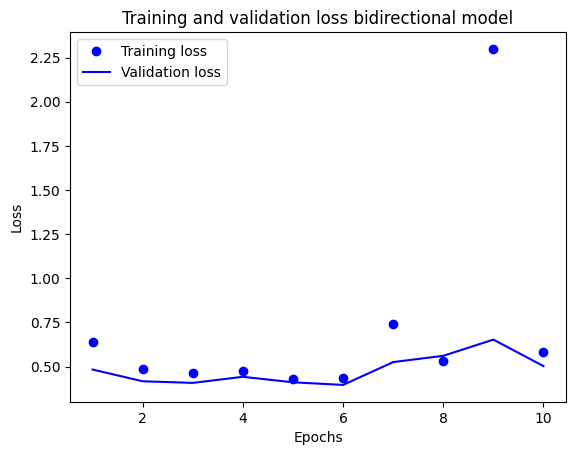

In [31]:

epochs = range(1, len(acc_bidirectional_model) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_bidirectional_model, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss_bidirectional_model, 'b', label='Validation loss')
plt.title('Training and validation loss bidirectional model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

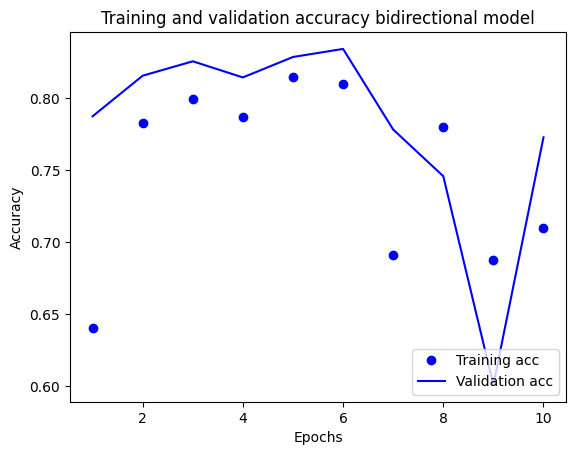

In [32]:
plt.plot(epochs, acc_bidirectional_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_bidirectional_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy bidirectional model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### LSTM model

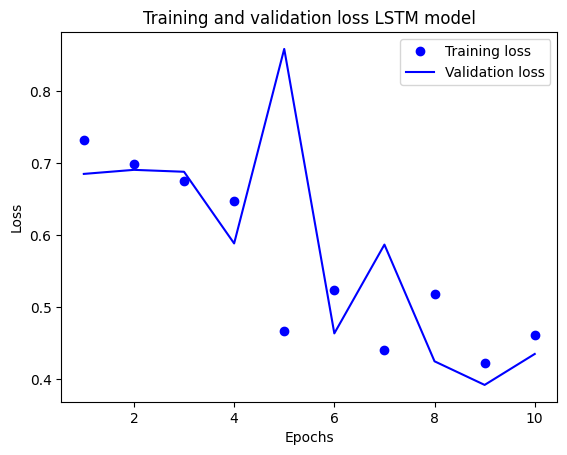

In [33]:
epochs = range(1, len(acc_LSTM_model) + 1)
plt.plot(epochs, loss_LSTM_model, 'bo', label='Training loss')
plt.plot(epochs, val_loss_LSTM_model, 'b', label='Validation loss')
plt.title('Training and validation loss LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

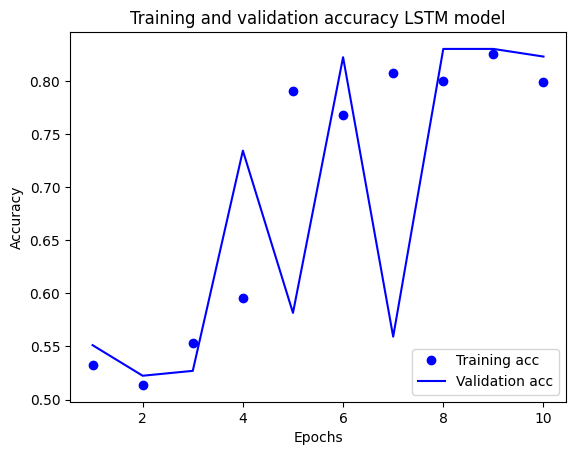

In [34]:
plt.plot(epochs, acc_LSTM_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_LSTM_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Average model

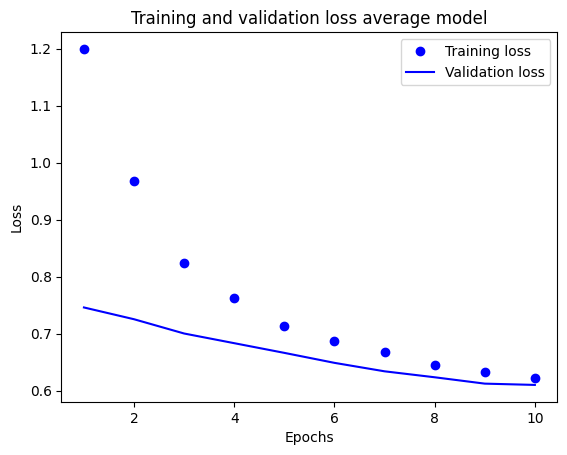

In [35]:
epochs = range(1, len(acc_average_model) + 1)
plt.plot(epochs, loss_average_model, 'bo', label='Training loss')
plt.plot(epochs, val_loss_average_model, 'b', label='Validation loss')
plt.title('Training and validation loss average model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

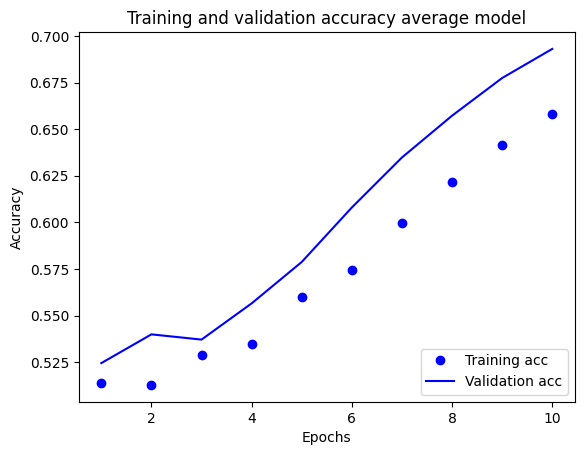

In [36]:
plt.plot(epochs, acc_average_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_average_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy average model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### CNN model

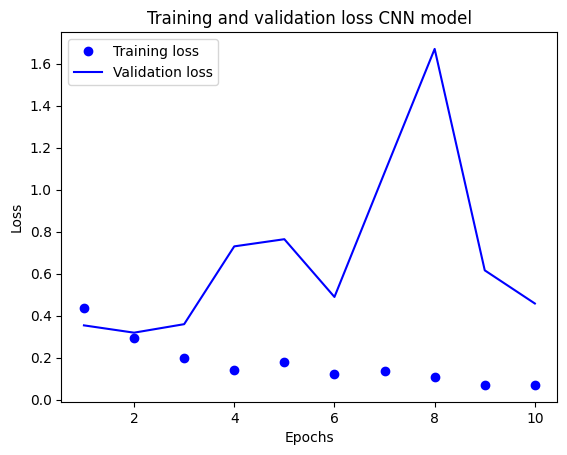

In [37]:
epochs = range(1, len(acc_CNN_model) + 1)
plt.plot(epochs, loss_CNN_model, 'bo', label='Training loss')
plt.plot(epochs, val_loss_CNN_model, 'b', label='Validation loss')
plt.title('Training and validation loss CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

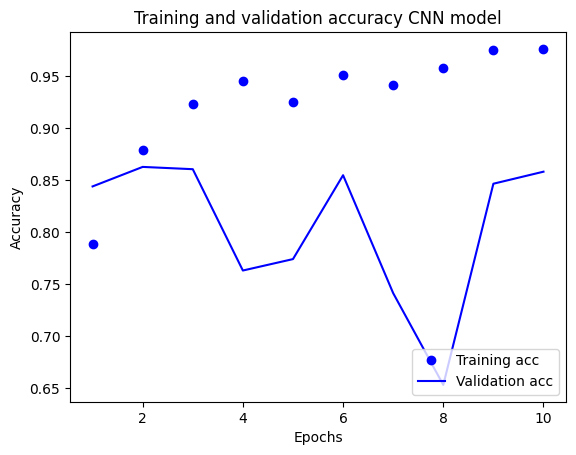

In [38]:
plt.plot(epochs, acc_CNN_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_CNN_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy CNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


## All models training and validation loss

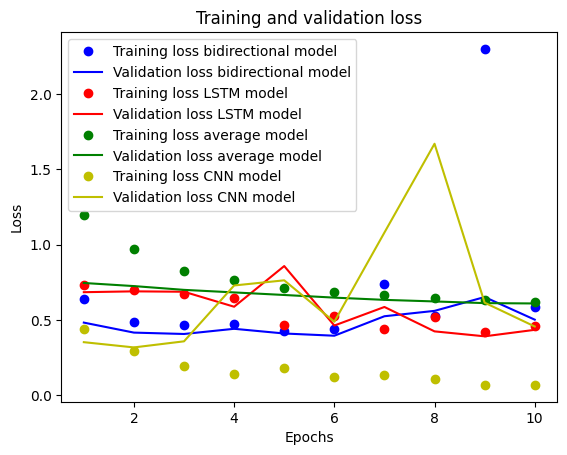

In [39]:
# "bo" is for "blue dot"
plt.plot(epochs, loss_bidirectional_model, 'bo', label='Training loss bidirectional model')
# b is for "solid blue line"
plt.plot(epochs, val_loss_bidirectional_model, 'b', label='Validation loss bidirectional model')

plt.plot(epochs, loss_LSTM_model, 'ro', label='Training loss LSTM model')
plt.plot(epochs, val_loss_LSTM_model, 'r', label='Validation loss LSTM model')

plt.plot(epochs, loss_average_model, 'go', label='Training loss average model')
plt.plot(epochs, val_loss_average_model, 'g', label='Validation loss average model')

plt.plot(epochs, loss_CNN_model, 'yo', label='Training loss CNN model')
plt.plot(epochs, val_loss_CNN_model, 'y', label='Validation loss CNN model')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Try the model with new input

In [ ]:
example, _ = vectorize_text('such a horrible movie, would not recommend',0)
new_bidirectional_model.predict(example)

## pos label is 1, neg label is 0

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  new_bidirectional_model,
  tf.keras.layers.Lambda(lambda x: tf.where(x >= 0.5, 'pos', 'neg'))
])

In [ ]:
examples = tf.constant([
  "The movie was great!",
  "The movie was the best.",
  "such a horrible movie, would not recommend",
  "Too much like a musical. Not enough action, majority of the time was in court and didn’t really anywhere with this story. I felt like they really dropped the ball on this one. Sounds rough but save your money, you didn’t miss much"
])
export_model.predict(examples)

In [ ]:
tomato_paths = 'data/reviews.csv'
tomato_test = pd.read_csv(tomato_paths)
tomato_test.head()
text_column = tomato_test['review']

text_column.values
text_ds = tf.constant(text_column.values)
ans = export_model.predict(text_ds)
ans = ans.flatten().astype(str)
labels, counts = np.unique(ans, return_counts=True)
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()